In [1]:
from torchvision import datasets

path2data = "./data"

train_data = datasets.MNIST(path2data, train=True, download=False)

x_train, y_train = train_data.data, train_data.targets
print(x_train.shape)
print(y_train.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])


In [2]:
val_data = datasets.MNIST(path2data, train=False, download=True)

x_val, y_val = val_data.data, val_data.targets
print(x_val.shape)
print(y_val.shape)

torch.Size([10000, 28, 28])
torch.Size([10000])


In [3]:
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

if len(x_train.shape)==3:
    x_train=x_train.unsqueeze(1)
print(x_train.shape)

if len(x_val.shape)==3:
    x_val=x_val.unsqueeze(1)



torch.Size([60000, 1, 28, 28])


torch.Size([3, 152, 242])


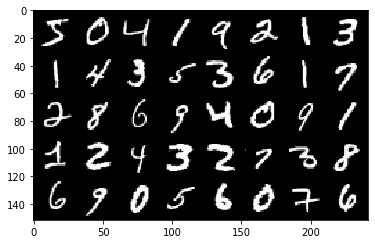

In [4]:
x_grid=utils.make_grid(x_train[:40], nrow=8, padding=2)
print(x_grid.shape)
def show(img):
    npimg = img.numpy()
    npimg_tr = np.transpose(npimg,(1,2,0))
    plt.imshow(npimg_tr,interpolation='nearest')
show(x_grid)

# Data Transformation

In [5]:
from torchvision import transforms

train_data=datasets.MNIST(path2data, train=True, download=True)

data_transform = transforms.Compose([transforms.RandomHorizontalFlip(p=1),
                                    transforms.RandomVerticalFlip(p=1),
                                    transforms.ToTensor(),
                                    ])

Text(0.5, 1.0, 'transformed')

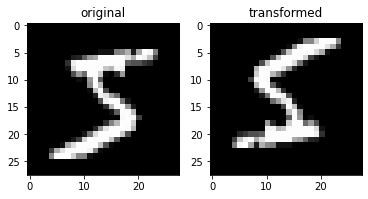

In [6]:
img = train_data[0][0]
img_tr=data_transform(img)
img_tr_np=img_tr.numpy()
# print(img_tr_np[0])
plt.subplot(1,2,1)
plt.imshow(img,cmap="gray")
plt.title("original")
plt.subplot(1,2,2)
plt.imshow(img_tr_np[0],cmap="gray");
plt.title("transformed")

In [7]:
# define transformations
data_transform = transforms.Compose([
                                        transforms.RandomHorizontalFlip(1),
                                        transforms.RandomVerticalFlip(1),
                                        transforms.ToTensor(),])

# Loading MNIST training data with on-the-fly transformations
train_data=datasets.MNIST(path2data, train=True, download=True,
transform=data_transform )

## Wrapping tensors into a dataset

In [8]:
from torch.utils.data import TensorDataset

train_ds = TensorDataset(x_train, y_train)
val_ds = TensorDataset(x_val, y_val)

for x,y in train_ds:
    print(x.shape,y.item())
    break



torch.Size([1, 28, 28]) 5


## Creating data loaders


In [9]:
from torch.utils.data import DataLoader

train_dl = DataLoader(train_ds, batch_size=8)
val_dl = DataLoader(val_ds, batch_size=8)

for xb,yb in train_dl:
    print(xb.shape)
    print(yb.shape)
    break

torch.Size([8, 1, 28, 28])
torch.Size([8])


# Building models

In [10]:
from torch import nn
import torch 

# input tensor dimension 64*1000
input_tensor = torch.randn(64, 1000)

# linear layer with 1000 inputs and 100 outputs
linear_layer = nn.Linear(1000, 100)

# output of the linear layer
output = linear_layer(input_tensor)
print(output.size())

torch.Size([64, 100])


In [11]:
from torch import nn

model= nn.Sequential(
    nn.Linear(4,5),
    nn.ReLU(),
    nn.Linear(5,1),
)
print(model)

Sequential(
  (0): Linear(in_features=4, out_features=5, bias=True)
  (1): ReLU()
  (2): Linear(in_features=5, out_features=1, bias=True)
)


### Neural Network

In [12]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5,1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [13]:

model = Net()
print(model)

Net(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)


### CUDA

In [14]:
print(next(model.parameters()).device)

cpu


In [15]:
device = torch.device("cuda:0")
model.to(device)
print(next(model.parameters()).device)

cuda:0


### Printing Model Summary

In [16]:
from torchsummary import summary

summary(model, input_size=(1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 24, 24]             520
            Conv2d-2             [-1, 50, 8, 8]          25,050
            Linear-3                  [-1, 500]         400,500
            Linear-4                   [-1, 10]           5,010
Total params: 431,080
Trainable params: 431,080
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 1.64
Estimated Total Size (MB): 1.76
----------------------------------------------------------------


### Loss Function

In [17]:
from torch import nn

loss_func = nn.NLLLoss(reduction="sum")

In [18]:
for xb, yb in train_dl:
    # move batch to cuda device
    xb=xb.type(torch.float).to(device)
    yb=yb.to(device)
    # get model output
    out=model(xb)
    # calculate loss value
    loss = loss_func(out, yb)
    print (loss.item())
    break

66.37258911132812


In [19]:
loss.backward()

### Optimizer

In [20]:
from torch import optim
opt = optim.Adam(model.parameters(), lr=1e-4)

In [21]:
opt.step()

In [22]:
opt.zero_grad()

### Training and Evaluation

In [23]:
def loss_batch(loss_func, xb, yb, yb_h, opt=None):
    loss = loss_func(yb_h, yb)
    metric_b = metrics_batch(yb, yb_h)
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    return loss.item(), metric_b

In [24]:
def metrics_batch(target, output):
    pred = output.argmax(dim=1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects

In [25]:
def loss_epoch(model, loss_func, dataset_dl, opt=None):
    loss=0.0
    metric=0.0
    len_data = len(dataset_dl.dataset)
    for xb, yb in dataset_dl:
        xb=xb.type(torch.float).to(device)
        yb=yb.to(device)
        yb_h=model(xb)
        
        loss_b,metric_b=loss_batch(loss_func, xb, yb, yb_h, opt)
        loss+=loss_b
        if metric_b is not None:
            metric+=metric_b
    loss/=len_data
    metric/=len_data
    return loss, metric

In [26]:
def train_val(epochs, model, loss_func, opt, train_dl, val_dl):
    for epoch in range(epochs):
        model.train()
        train_loss, train_metric=loss_epoch(model, loss_func, train_dl, opt)
        model.eval()
        with torch.no_grad():
            val_loss, val_metric=loss_epoch(model, loss_func, val_dl)
        accuracy=100*val_metric
        
        print("epoch: %d, train loss: %.6f, val loss:%.6f, accuracy:%.2f" %(epoch, train_loss,val_loss, accuracy))

In [27]:
num_epochs = 5
train_val(num_epochs, model, loss_func, opt, train_dl, val_dl)

epoch: 0, train loss: 0.139836, val loss:0.082927, accuracy:97.22
epoch: 1, train loss: 0.046117, val loss:0.045355, accuracy:98.65
epoch: 2, train loss: 0.027448, val loss:0.061011, accuracy:98.23
epoch: 3, train loss: 0.019149, val loss:0.054320, accuracy:98.55
epoch: 4, train loss: 0.015241, val loss:0.046051, accuracy:98.74


### Storing and Loading models

In [28]:
path2weights="./models/weights.pt"

torch.save(model.state_dict(), path2weights)

In [29]:
_model = Net()

In [30]:
weights=torch.load(path2weights)

In [31]:
_model.load_state_dict(weights)

<All keys matched successfully>

In [32]:
path2model="./models/model.pt"

torch.save(model, path2model)

In [33]:
_model=Net()

In [34]:
_model=torch.load(path2model)

### Deploying the Model

torch.Size([1, 28, 28])


torch.Size([1, 28, 28])

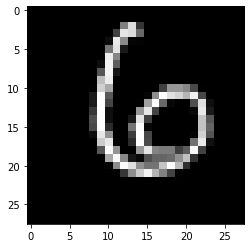

In [35]:
n = 100
x = x_val[n]
y = y_val[n]
print(x.shape)
plt.imshow(x.numpy()[0],cmap="gray")

torch.Size([1, 28, 28])

In [36]:
x = x.unsqueeze(0)

x = x.type(torch.float)

x = x.to(device)

In [38]:
output = _model(x)

pred = output.argmax(dim=1, keepdim=True)
print(pred.item(), y.item())



6 6
